# K-Means Clustering

The final goal of the code file is to build a system that recommends scientific papers (research papers) based on content similarity. Specifically:

* Use Universal Sentence Encoder (USE) to convert the titles, authors, and abstracts of the papers into numeric vectors (embeddings). (reused from /parquets)
* Apply the K-Means Clustering algorithm to group the papers into clusters with similar content.
* Use the Cosine Similarity measure to recommend other papers in the same cluster as the paper that the user is interested in.
* Evaluate the optimal number of clusters using Silhouette Score and visualize the results using PCA.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/cleaned.parquet.gzip")

Tuning the number of clusters (K) using silhouette score...
K=5, Silhouette Score=0.0120
K=10, Silhouette Score=-0.0065
K=15, Silhouette Score=-0.0142
K=20, Silhouette Score=-0.0093
K=25, Silhouette Score=-0.0209
K=30, Silhouette Score=-0.0203
K=35, Silhouette Score=-0.0247
K=40, Silhouette Score=-0.0237
K=45, Silhouette Score=-0.0305
K=50, Silhouette Score=-0.0262

Best number of clusters (K): 5


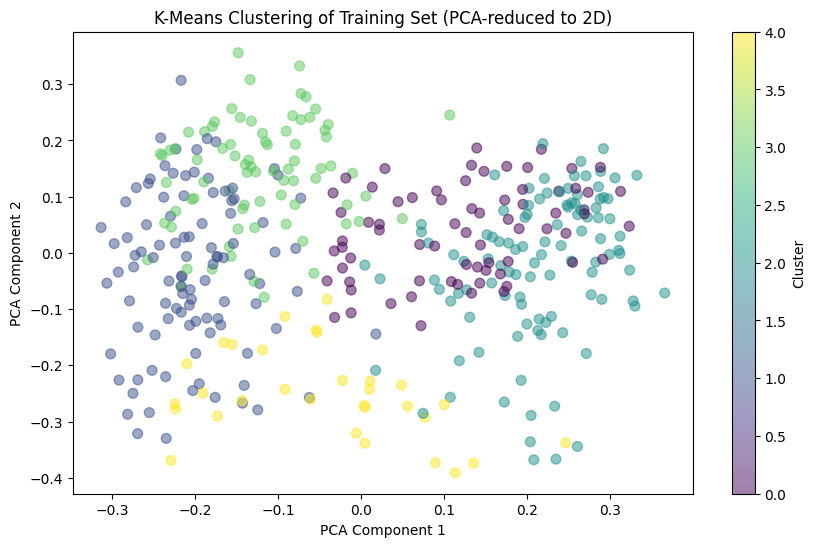

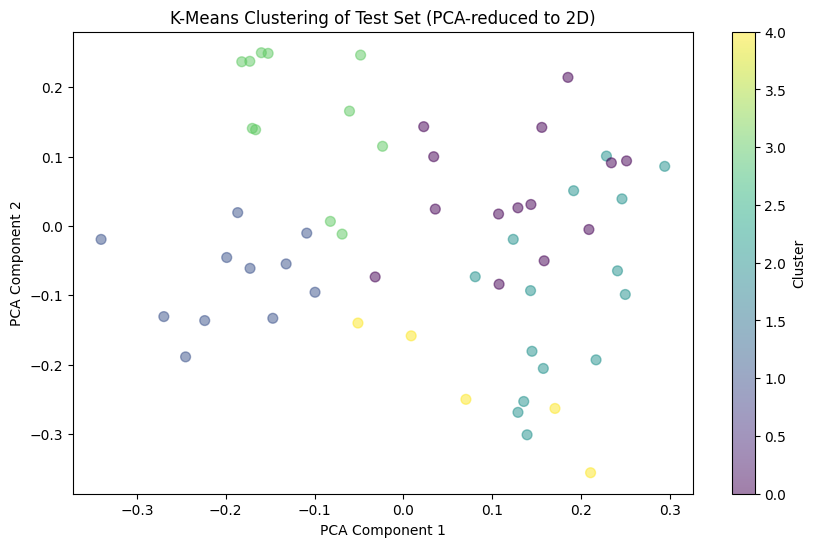


Testing recommender system for paper at test index 0 (Cluster 0):
Average cosine similarity to papers in the same cluster: 0.38919734954833984
Average cosine similarity to random papers: 0.42258042097091675

Test paper title: Replay Attack Detection Using Linear Prediction Analysis-Based Relative Phase Features

Recommended papers based on clustering:
1. Robust Network Intrusion Detection System Based on Machine-Learning With Early Classification
2. A Distributed Survivable Routing Algorithm for Mega-Constellations With Inclined Orbits
3. Identifying Incorrect Patches in Program Repair Based on Meaning of Source Code
4. Three-Dimensional Reconstruction of Fuzzy Medical Images Using Quantum Algorithm
5. A Fast Fusion Method for Visible and Infrared Images Using Fourier Transform and Difference Minimization


In [3]:
# Define the embedding columns (512 dimensions each for title, authors, abstract)
title_cols = [f"title_emb_{i}" for i in range(512)]
authors_cols = [f"authors_emb_{i}" for i in range(512)]
abstract_cols = [f"abstract_emb_{i}" for i in range(512)]
all_emb_cols = title_cols + authors_cols + abstract_cols  # Total 1536 features

# Extract feature matrices from the DataFrames
X_train = trnDF[all_emb_cols].values
X_val = valDF[all_emb_cols].values
X_test = tstDF[all_emb_cols].values

# Normalize the feature vectors to unit norm (for cosine similarity equivalence)
X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_test_norm = normalize(X_test)

# Tune the number of clusters (K) using silhouette score on the validation set
k_values = range(5, 51, 5)  # Test K from 5 to 50 with step 5
silhouette_scores = []

print("Tuning the number of clusters (K) using silhouette score...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_norm)  # Fit on training data
    val_labels = kmeans.predict(X_val_norm)  # Predict clusters for validation data
    # Use a sample size for efficiency (e.g., 1000 points)
    score = silhouette_score(X_val_norm, val_labels, sample_size=1000, random_state=42)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Select the best K based on the highest silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters (K): {best_k}")

# Train the final K-Means model with the best K on the training data
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_final.fit(X_train_norm)

# Assign clusters to the test set
test_labels = kmeans_final.predict(X_test_norm)

# ---- Visualization ----
# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_norm)

# Plot the training set clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_final.labels_, cmap='viridis', s=50, alpha=0.5)
plt.title('K-Means Clustering of Training Set (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot the test set clusters
X_test_pca = pca.transform(X_test_norm)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap='viridis', s=50, alpha=0.5)
plt.title('K-Means Clustering of Test Set (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# ---- Testing the Recommender System ----
# Select a test paper (e.g., the first one in the test set)
test_paper_index = 0
test_paper_cluster = test_labels[test_paper_index]
print(f"\nTesting recommender system for paper at test index {test_paper_index} (Cluster {test_paper_cluster}):")

# Find other papers in the same cluster (excluding the test paper itself)
same_cluster_indices = np.where(test_labels == test_paper_cluster)[0]
same_cluster_indices = same_cluster_indices[same_cluster_indices != test_paper_index]

# Compute cosine similarity between the test paper and others in the same cluster
test_paper_vector = X_test_norm[test_paper_index].reshape(1, -1)
if len(same_cluster_indices) > 0:
    similarities = cosine_similarity(test_paper_vector, X_test_norm[same_cluster_indices])
    average_similarity = np.mean(similarities)
else:
    average_similarity = None
    print("Note: No other papers in the same cluster.")

# Compute cosine similarity to a random set of papers for comparison
random_indices = np.random.choice(len(X_test_norm), size=min(10, len(same_cluster_indices)), replace=False)
random_similarities = cosine_similarity(test_paper_vector, X_test_norm[random_indices])
average_random_similarity = np.mean(random_similarities)

# Display similarity results
print(f"Average cosine similarity to papers in the same cluster: {average_similarity if average_similarity else 'N/A'}")
print(f"Average cosine similarity to random papers: {average_random_similarity}")

# Retrieve and display the titles for manual inspection
test_paper_id = tstDF.iloc[test_paper_index]["id"]
test_paper_title = cleanedDF[cleanedDF["Id"] == test_paper_id]["title"].values[0]
print(f"\nTest paper title: {test_paper_title}")

if len(same_cluster_indices) > 0:
    recommended_ids = tstDF.iloc[same_cluster_indices]["id"].values
    recommended_titles = cleanedDF[cleanedDF["Id"].isin(recommended_ids)]["title"].values
    print("\nRecommended papers based on clustering:")
    for i, title in enumerate(recommended_titles[:5], 1):  # Limit to 5 for brevity
        print(f"{i}. {title}")
else:
    print("\nNo recommended papers (cluster contains only the test paper).")

**Evaluation:**

***Find 5 most similar papers to a specific test paper index***


Computing similarity matrix for the test set...
Similarity matrix shape: (56, 56)
Mean similarity: 0.3011
Min similarity: 0.0580
Max similarity (excluding diagonal): 0.5455

Subset similarity matrix (first 56 papers) shape: (56, 56)
Mean similarity (subset): 0.3011

Top 5 most similar papers to test paper (index 1) based on similarity matrix:
1. Land Use Classification Using High-Resolution Remote Sensing Images Based on Structural Topic Model (Cosine Similarity: 0.5301)
2. A Fast Fusion Method for Visible and Infrared Images Using Fourier Transform and Difference Minimization (Cosine Similarity: 0.4474)
3. Replay Attack Detection Using Linear Prediction Analysis-Based Relative Phase Features (Cosine Similarity: 0.4407)
4. Neural Image Compression and Explanation (Cosine Similarity: 0.4374)
5. Lighting-and Personal Characteristic-Aware Markov Random Field Model for Facial Image Relighting System (Cosine Similarity: 0.4232)


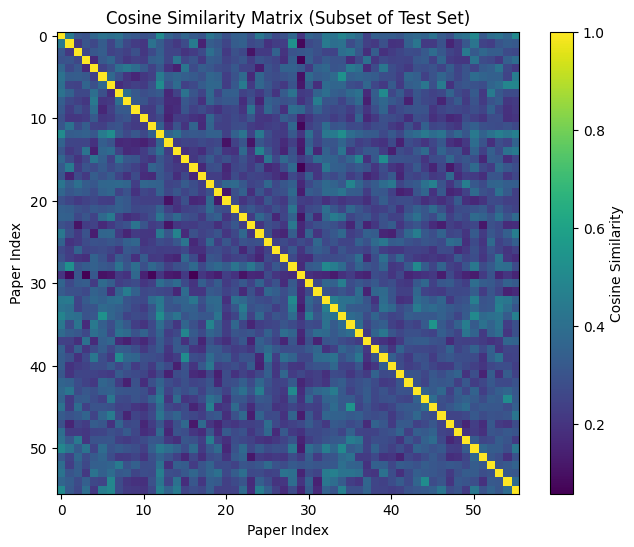

In [6]:
# ---- Similarity Matrix Evaluation ----
print("\nComputing similarity matrix for the test set...")

# Compute the full cosine similarity matrix for the test set
# Note: This can be memory-intensive for large datasets
similarity_matrix = cosine_similarity(X_test_norm)

# Display basic statistics about the similarity matrix
print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Mean similarity: {np.mean(similarity_matrix):.4f}")
print(f"Min similarity: {np.min(similarity_matrix):.4f}")
print(f"Max similarity (excluding diagonal): {np.max(similarity_matrix - np.eye(similarity_matrix.shape[0])):.4f}")

# Optional: Evaluate similarity matrix for a subset (e.g., first 100 papers) for efficiency
subset_size = min(100, len(X_test_norm))  # Limit to 100 or total size if smaller
subset_similarity_matrix = cosine_similarity(X_test_norm[:subset_size])
print(f"\nSubset similarity matrix (first {subset_size} papers) shape: {subset_similarity_matrix.shape}")
print(f"Mean similarity (subset): {np.mean(subset_similarity_matrix):.4f}")

# Example: Find top 5 most similar papers to the test paper (index 1) using the similarity matrix
test_paper_index = 1
test_paper_similarities = similarity_matrix[test_paper_index]
# Exclude the paper itself (similarity = 1.0)
top_similar_indices = np.argsort(test_paper_similarities)[::-1][1:6]  # Top 5, excluding self
top_similarities = test_paper_similarities[top_similar_indices]

# Retrieve titles for the top similar papers
top_similar_ids = tstDF.iloc[top_similar_indices]["id"].values
top_similar_titles = cleanedDF[cleanedDF["Id"].isin(top_similar_ids)]["title"].values

print(f"\nTop 5 most similar papers to test paper (index {test_paper_index}) based on similarity matrix:")
for i, (title, sim) in enumerate(zip(top_similar_titles, top_similarities), 1):
    print(f"{i}. {title} (Cosine Similarity: {sim:.4f})")

# Optional: Visualize the similarity matrix for the subset as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(subset_similarity_matrix, cmap='viridis')
plt.title('Cosine Similarity Matrix (Subset of Test Set)')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Paper Index')
plt.ylabel('Paper Index')
plt.show()

***An input string: "Smart Optical Sensors"***

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import re

# Load and preprocess the data
def load_and_preprocess_data(file_content):
    # Since we're working with the provided CSV content directly
    df = pd.read_csv('/content/drive/MyDrive/dataset/database_clean.csv')

    # Combine title and abstract for better feature representation
    df['text'] = df['title'] + ' ' + df['abstract']

    # Clean text
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text

    df['text'] = df['text'].apply(clean_text)
    return df

# Create TF-IDF features and perform K-means clustering
def create_clusters(df, n_clusters=3):
    # Create TF-IDF features
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf.fit_transform(df['text'])

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)

    df['cluster'] = clusters
    return df, tfidf, tfidf_matrix, kmeans

# Build recommender system
class ResearchPaperRecommender:
    def __init__(self, df, tfidf, tfidf_matrix, kmeans):
        self.df = df
        self.tfidf = tfidf
        self.tfidf_matrix = tfidf_matrix
        self.kmeans = kmeans

    def recommend_papers(self, query, top_n=3):
        # Preprocess query
        query = str(query).lower()
        query = re.sub(r'[^\w\s]', '', query)

        # Transform query to TF-IDF space
        query_tfidf = self.tfidf.transform([query])

        # Predict cluster for query
        query_cluster = self.kmeans.predict(query_tfidf)[0]

        # Get papers from the same cluster
        cluster_papers = self.df[self.df['cluster'] == query_cluster]

        # Calculate cosine similarity between query and cluster papers
        cluster_indices = cluster_papers.index
        cluster_tfidf = self.tfidf_matrix[cluster_indices]
        similarities = cosine_similarity(query_tfidf, cluster_tfidf)[0]

        # Add similarity scores to dataframe
        cluster_papers = cluster_papers.copy()
        cluster_papers['similarity'] = similarities

        # Sort by similarity and return top N
        recommendations = cluster_papers.sort_values('similarity', ascending=False).head(top_n)

        return recommendations[['title', 'authors', 'year', 'link', 'similarity']]

# Compute similarity matrix for evaluation
def compute_similarity_matrix(tfidf_matrix):
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

# Main execution
def main():
    # Load and preprocess data
    df = load_and_preprocess_data('/content/drive/MyDrive/dataset/database_clean.csv')

    # Create clusters
    df, tfidf, tfidf_matrix, kmeans = create_clusters(df, n_clusters=3)

    # Initialize recommender
    recommender = ResearchPaperRecommender(df, tfidf, tfidf_matrix, kmeans)

    # Example usage
    query = "Smart Optical Sensors"
    recommendations = recommender.recommend_papers(query, top_n=3)

    # Print recommendations
    print(f"\nTop 3 recommended papers for query: '{query}'")
    print("=" * 50)
    for idx, row in recommendations.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Year: {row['year']}")
        print(f"Link: {row['link']}")
        print(f"Similarity Score: {row['similarity']:.4f}")
        print("-" * 50)

    # Compute and evaluate similarity matrix
    similarity_matrix = compute_similarity_matrix(tfidf_matrix)
    print("\nSimilarity Matrix Shape:", similarity_matrix.shape)
    print("Average similarity between documents:", np.mean(similarity_matrix))

    # Print cluster distribution
    print("\nCluster Distribution:")
    print(df['cluster'].value_counts())

if __name__ == "__main__":
    main()


Top 3 recommended papers for query: 'Smart Optical Sensors'
Title: A Hybrid Deep Learning Approach for Replay and DDoS Attack Detection in a Smart City
Authors: ['Asmaa A. Elsaeidy', 'Abbas Jamalipour', 'Kumudu S. Munasinghe']
Year: 2021
Link: /document/9617591/
Similarity Score: 0.2607
--------------------------------------------------
Title: Smart Optical Sensors for Internet of Things: Integration of Temperature Monitoring and Customized Security Physical Unclonable Functions
Authors: ['Lília M. S. Dias', 'João F. C. B. Ramalho', 'Tiago Silvério', 'Lianshe Fu', 'Rute A. S. Ferreira', 'Paulo S. André']
Year: 2022
Link: /document/9718070/
Similarity Score: 0.2375
--------------------------------------------------
Title: Adaptive Transceiver Architecture With QoS Provision for OCDMA Network Based on Logic Gates
Authors: ['Hassan Yousif Ahmed', 'Medien Zeghid', 'Waqas Ahmed Imtiaz', 'Teena Sharma', 'Akhtar Nawaz Khan', 'Kottakkaran Sooppy Nisar', 'Abdel-Haleem Abdel-Aty', 'Mona Mahmoud